In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from heatmap import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import pandas_profiling
pd.set_option('use_inf_as_na', True)

In [2]:
from scipy import stats
def chiSquare(depVar, indepVar):
    contTable = pd.crosstab(indepVar, depVar, margins=False)
    print(contTable)
    obsV = np.array(contTable)
    chi2_stat, p_val, dof, ex = stats.chi2_contingency(obsV)
    print("===Chi2 Stat===")
    print(chi2_stat)
    print("\n")
    print("===Degrees of Freedom===")
    print(dof)
    print("\n")
    print("===P-Value===")
    print(p_val)
    print("\n")
    print("===Contingency Table===")
    print(ex)
    return obsV
    

In [2]:
print("Dens")
with open("../rawData/ischDB/density.csv", 'r') as densFile:
    dens = pd.read_csv(densFile, sep=",", encoding='utf-8', dtype={"Season":"int"}, parse_dates=["Date"])
print("Eggs")
with open("../rawData/ischDB/eggs.csv", 'r') as eggFile:
    eggs= pd.read_csv(eggFile, sep=",", encoding='utf-8',parse_dates=["Date"])
print("ind")
with open("../rawData/ischDB/individuals.csv", 'r') as indFile:
    ind=pd.read_csv(indFile, sep=",", encoding = 'utf-8', parse_dates=["Date"], dtype={"Sex":"object", "Copula":"object", "Part_ID":"object", "Morph":"object", "Data_entry":"object"})

dens.columns = dens.columns.str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '_').str.replace('.', '')
eggs.columns = eggs.columns.str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '_').str.replace('.', '')
ind.columns = ind.columns.str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '_').str.replace('.', '')

eggs["Locale"].loc[eggs["Locale"]=="IKEA"]="Ikea"
ind["Locale"].loc[ind["Locale"]=="IKEA"]="Ikea"
ind["Locale"].loc[ind["Locale"]=="Vombs vattenverk"]="Vombs Vattenverk"

Dens
Eggs
ind


c:\users\lorenzo\appdata\local\programs\python\python36-32\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [3]:
dens.profile_report()

In [ ]:
eggs.profile_report()

In [3]:
ind.profile_report()

In [3]:
dens["No_females"].fillna(value=0, inplace=True)
dens["No_males"].fillna(value=0, inplace=True)
ind["Morph"].fillna(value="unknown", inplace=True)
ind["Locale"].fillna(value="unknown", inplace=True)

dens["No_indiv"] = dens["No_females"]+dens["No_males"]
dens["cpm"] = dens["No_indiv"]/dens["Catching_time_min"]
eggInd = pd.merge(eggs, ind, on='Season_ID')
eggInd = eggInd[eggInd["Morph"]!= "unknown"]
#eggInd = eggInd[pd.isnull(eggInd["Col_phas"])]


In [21]:
#print(dens.Locale.value_counts()[:10])
lomma = dens[dens["Locale"]=="Habo Gard"]
And = lomma.groupby("Season")['No_androchromes'].sum()
Fem = lomma.groupby("Season")['No_females'].sum()
#lomma["AFreq"] = lomma["No_androchromes"]/lomma["No_females"]
#sns.relplot(x=, y="AFreq", data=lomma)
print(And/Fem)



Season
2001    0.676768
2002    0.549451
2003    0.400000
2004    0.333333
2005    0.480000
2006    0.415584
2007    0.521277
2008    0.520000
2009    0.276786
2010    0.200000
2011    0.171429
2012    0.300000
2013    0.218750
2014    0.461538
2015    0.076923
2016    0.260870
2017    0.421053
2018    0.393939
2019         NaN
dtype: float64


c:\users\lorenzo\appdata\local\programs\python\python36-32\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:             No_females   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     2808.
Date:                Mon, 02 Sep 2019   Prob (F-statistic):               0.00
Time:                        11:04:02   Log-Likelihood:                -5741.3
No. Observations:                1707   AIC:                         1.149e+04
Df Residuals:                    1705   BIC:                         1.150e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
No_males       0.5732      0.011     52.994      0.0

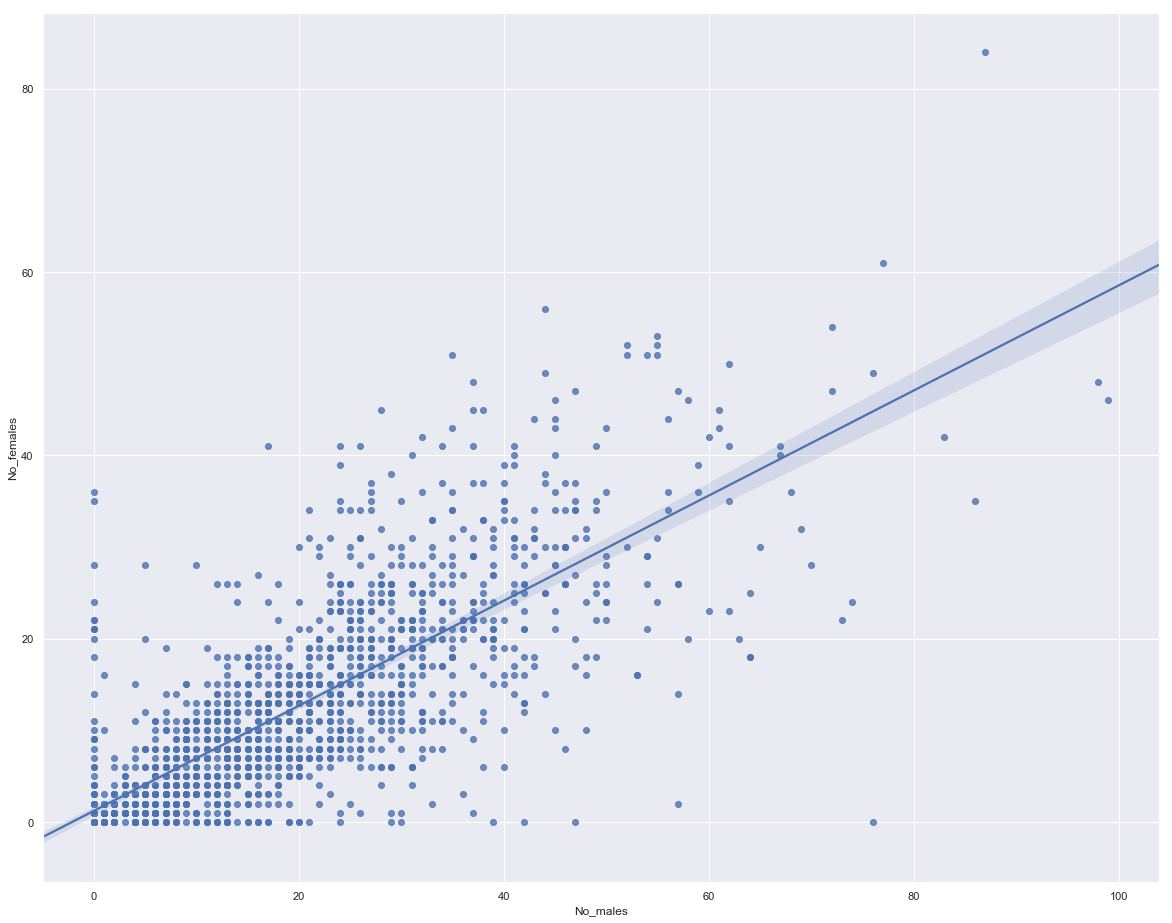

In [5]:
densSub = dens[dens.groupby("Locale")["Locale"].transform('count')>9]
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="No_males", y="No_females", data=dens, ax=axarr)
est=sm.OLS(dens["No_females"], sm.add_constant(dens["No_males"], prepend=False)).fit()
print(est.summary())

In [6]:
eggMorphFit = smf.ols(formula="Egg_count~C(Morph)", data=eggInd).fit()
print(eggMorphFit.summary())
table=sm.stats.anova_lm(eggMorphFit,typ=2)
print(table)
mc = MultiComparison(eggInd["Egg_count"], eggInd["Morph"])
mc_results=mc.tukeyhsd()
print(mc_results)

print(eggInd["Egg_count"][eggInd["Morph"]=="infuscans"].mean())
print(eggInd["Egg_count"][eggInd["Morph"]!="infuscans"].mean())

"""
mc = MultiComparison(eggInd["Egg_count"], eggInd["Locale_y"])
mc_results=mc.tukeyhsd()
print(mc_results)
"""

                            OLS Regression Results                            
Dep. Variable:              Egg_count   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     21.81
Date:                Mon, 02 Sep 2019   Prob (F-statistic):           3.62e-10
Time:                        11:04:02   Log-Likelihood:                -41237.
No. Observations:                6390   AIC:                         8.248e+04
Df Residuals:                    6387   BIC:                         8.250e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

'\nmc = MultiComparison(eggInd["Egg_count"], eggInd["Locale_y"])\nmc_results=mc.tukeyhsd()\nprint(mc_results)\n'

In [7]:
eggInd["eggYN"] = eggInd["Egg_count"]
eggInd["eggYN"][eggInd["Egg_count"]>0] = 1

chiSquare(eggInd["eggYN"], eggInd["Morph"])

for i in range(1, len(eggInd.Morph.unique())):
    morph1 = eggInd.Morph.unique()[i]
    for j in range(i):
        morph2 = eggInd.Morph.unique()[j]
        subset = eggInd.loc[eggInd["Morph"].isin([morph1, morph2])]
        chiSquare(subset["eggYN"], subset["Morph"])

eggYN               0.0   1.0
Morph                        
androchrome         626  3364
infuscans           272  1766
infuscans-obsoleta   66   296
===Chi2 Stat===
8.744677986873137


===Degrees of Freedom===
2


===P-Value===
0.012621683979161018


===Contingency Table===
[[ 601.9342723  3388.0657277 ]
 [ 307.4541471  1730.5458529 ]
 [  54.61158059  307.38841941]]
eggYN        0.0   1.0
Morph                 
androchrome  626  3364
infuscans    272  1766
===Chi2 Stat===
5.656883246455134


===Degrees of Freedom===
1


===P-Value===
0.017386993911885223


===Contingency Table===
[[ 594.39615129 3395.60384871]
 [ 303.60384871 1734.39615129]]
eggYN               0.0   1.0
Morph                        
androchrome         626  3364
infuscans-obsoleta   66   296
===Chi2 Stat===
1.4202559673903161


===Degrees of Freedom===
1


===P-Value===
0.23336127669917933


===Contingency Table===
[[ 634.43933824 3355.56066176]
 [  57.56066176  304.43933824]]
eggYN               0.0   1.0
Morph     

c:\users\lorenzo\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
withEggs = eggInd[eggInd["eggYN"]==1]
eggMorphFit = smf.ols(formula="Egg_count~C(Morph)", data=withEggs).fit()
print(eggMorphFit.summary())
table=sm.stats.anova_lm(eggMorphFit,typ=2)
print(table)
mc = MultiComparison(withEggs["Egg_count"], withEggs["Morph"])
mc_results=mc.tukeyhsd()
print(mc_results)

print(withEggs["Egg_count"][withEggs["Morph"]=="infuscans"].mean())
print(withEggs["Egg_count"][withEggs["Morph"]!="infuscans"].mean())

                            OLS Regression Results                            
Dep. Variable:              Egg_count   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     19.05
Date:                Mon, 02 Sep 2019   Prob (F-statistic):           5.69e-09
Time:                        11:04:03   Log-Likelihood:                -34504.
No. Observations:                5426   AIC:                         6.901e+04
Df Residuals:                    5423   BIC:                         6.903e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [9]:
indSub = ind[ind.groupby("Locale")["Locale"].transform('count')>9]
paraFit = smf.ols(formula="Parasite~C(Locale)", data=indSub).fit()
print(paraFit.summary())
table = sm.stats.anova_lm(paraFit, typ=2)
print(table)

                            OLS Regression Results                            
Dep. Variable:               Parasite   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     178.5
Date:                Mon, 02 Sep 2019   Prob (F-statistic):               0.00
Time:                        11:04:03   Log-Likelihood:            -1.6382e+05
No. Observations:               49950   AIC:                         3.277e+05
Df Residuals:                   49925   BIC:                         3.279e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

c:\users\lorenzo\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
c:\users\lorenzo\appdata\local\programs\python\python36-32\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
c:\users\lorenzo\appdata\local\programs\python\python36-32\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
c:\users\lorenzo\appdata\local\programs\python\python36-32\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
c:\users\lorenzo\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The n

                            OLS Regression Results                            
Dep. Variable:              Egg_count   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     37.49
Date:                Mon, 02 Sep 2019   Prob (F-statistic):           9.82e-10
Time:                        11:04:04   Log-Likelihood:                -36851.
No. Observations:                5716   AIC:                         7.371e+04
Df Residuals:                    5714   BIC:                         7.372e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    198.0701      2.082     95.120      0.0

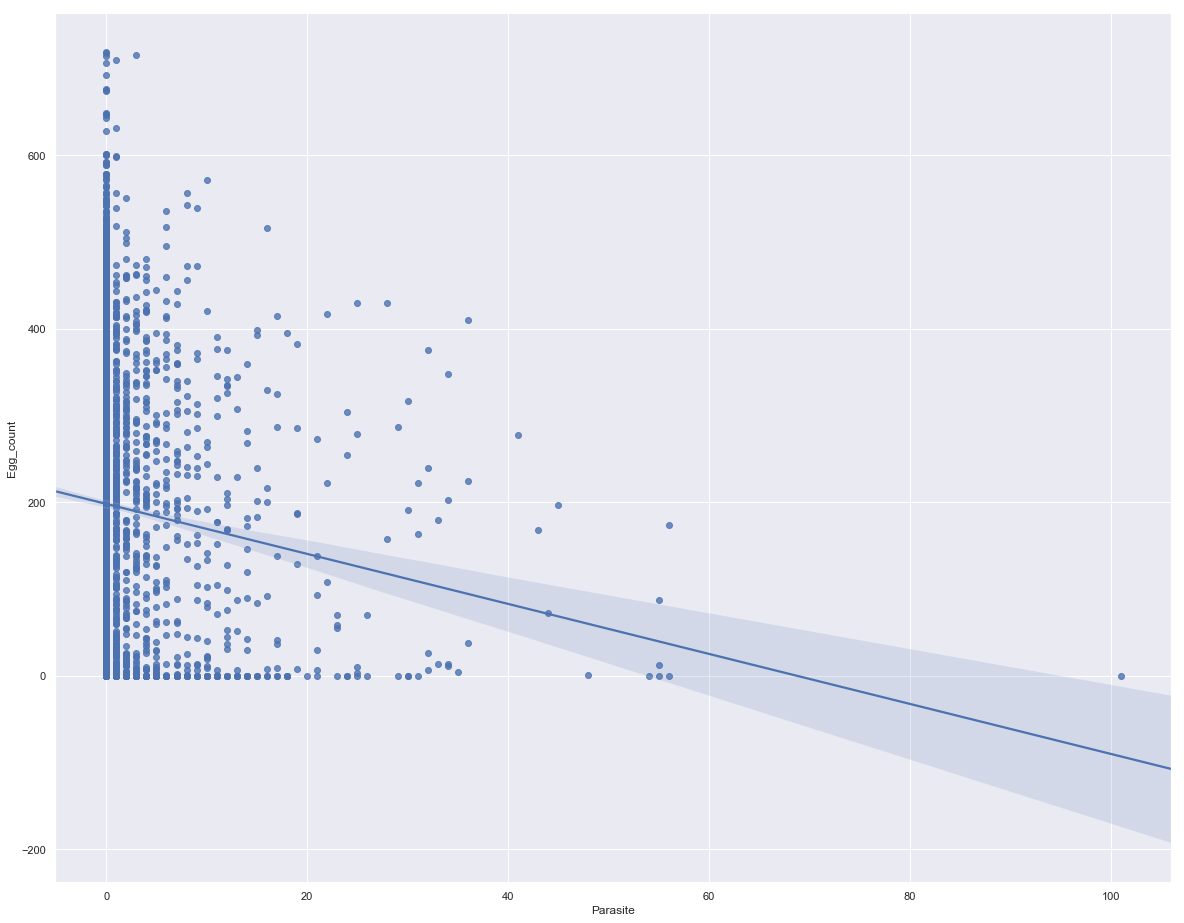

In [10]:
eggParFit = smf.ols(formula="Egg_count~Parasite", data=eggInd).fit()
print(eggParFit.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="Parasite", y="Egg_count", data=eggInd, ax=axarr)

In [11]:
print(paraFit.diagn)

{'jb': 47151377.19550998, 'jbpv': 0.0, 'skew': 9.264292186046942, 'kurtosis': 152.37204534778655, 'omni': 75179.48537699707, 'omnipv': 0.0, 'condno': 1.0348748223758022e+16, 'mineigval': 4.987018405435863e-28}


In [36]:
matureInd = ind[ind["Age"]=="mature"]
matureFem = matureInd[matureInd["Sex"]=='0'][matureInd["Morph"] != 'unknown'][pd.notnull(matureInd["Copula"])]
matureFem = matureFem[pd.isnull(matureFem["Col_phas"])]
print(matureFem["Col_phas"].value_counts(dropna=False))
print(matureFem["Morph"].value_counts(dropna=False))
print(matureFem["Copula"].value_counts(dropna=False))

NaN    11637
Name: Col_phas, dtype: int64
androchrome           8294
infuscans             2880
infuscans-obsoleta     463
Name: Morph, dtype: int64
1    6866
0    4771
Name: Copula, dtype: int64


c:\users\lorenzo\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
c:\users\lorenzo\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [49]:
print(ind[ind["Sex"]=='0'][ind["Age"]=="immature"]["Morph"].value_counts(dropna=False))

unknown               4412
androchrome            989
infuscans-obsoleta     343
infuscans              185
Name: Morph, dtype: int64


c:\users\lorenzo\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [37]:
copMorph = chiSquare(matureFem["Copula"], matureFem["Morph"])

Copula                 0     1
Morph                         
androchrome         4009  4285
infuscans            617  2263
infuscans-obsoleta   145   318
===Chi2 Stat===
658.7498770993105


===Degrees of Freedom===
2


===P-Value===
9.000812414025259e-144


===Contingency Table===
[[3400.41883647 4893.58116353]
 [1180.7579273  1699.2420727 ]
 [ 189.82323623  273.17676377]]


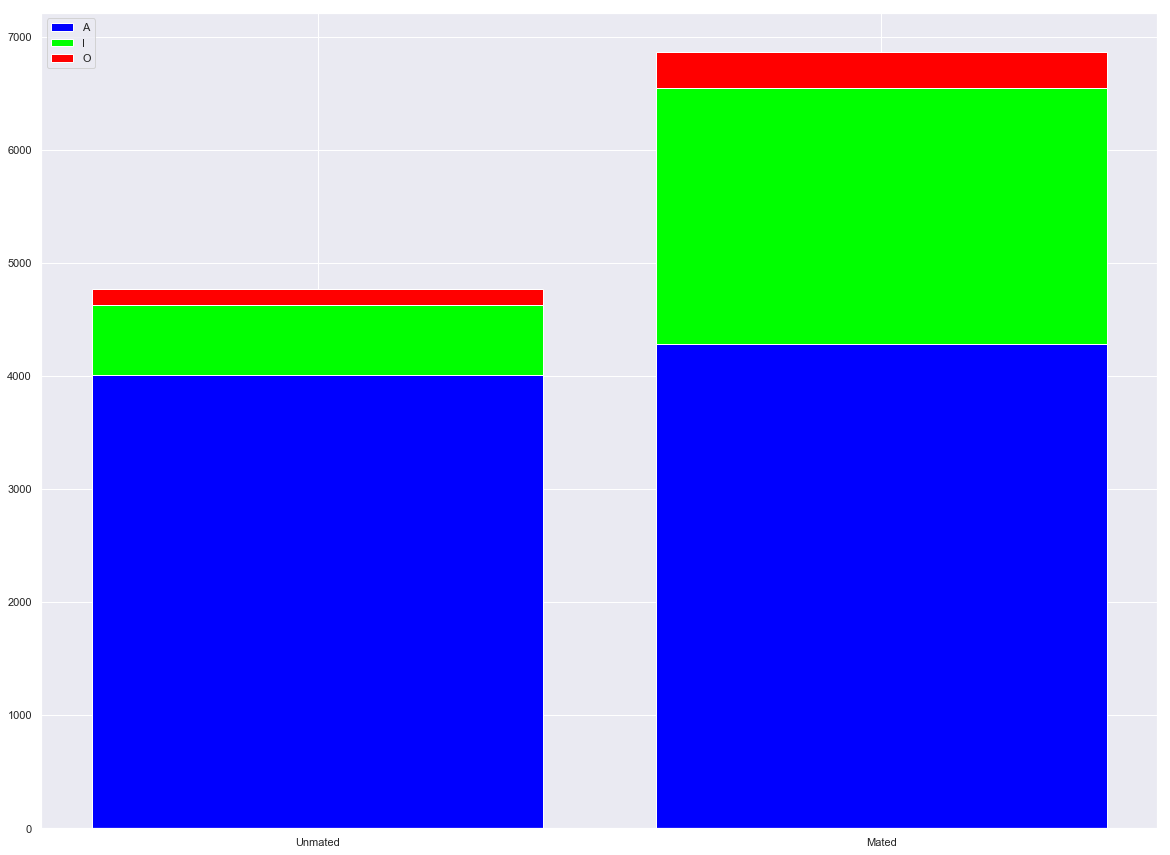

In [38]:
fig = plt.figure(figsize=(20,15))
categories=["Unmated", "Mated"]
p1=plt.bar(categories, copMorph[0], color='#0000ff')
p2=plt.bar(categories, copMorph[1], color='#00ff00', bottom=copMorph[0])
p3=plt.bar(categories, copMorph[2], color='#ff0000', bottom=copMorph[1]+copMorph[0])
plt.legend((p1[0], p2[0], p3[0]), ('A', 'I', 'O'))
plt.show()

In [39]:
for i in range(1, len(matureFem.Morph.unique())):
    morph1 = matureFem.Morph.unique()[i]
    for j in range(i):
        morph2 = matureFem.Morph.unique()[j]
        subset = matureFem.loc[matureFem["Morph"].isin([morph1, morph2])]
        print(chiSquare(subset["Copula"], subset["Morph"]))

Copula                 0     1
Morph                         
androchrome         4009  4285
infuscans-obsoleta   145   318
===Chi2 Stat===
50.25790217923855


===Degrees of Freedom===
1


===P-Value===
1.3481075016972793e-12


===Contingency Table===
[[3934.36976133 4359.63023867]
 [ 219.63023867  243.36976133]]
[[4009 4285]
 [ 145  318]]
Copula          0     1
Morph                  
androchrome  4009  4285
infuscans     617  2263
===Chi2 Stat===
637.0960361621765


===Degrees of Freedom===
1


===P-Value===
1.4305798788669477e-140


===Contingency Table===
[[3433.68927868 4860.31072132]
 [1192.31072132 1687.68927868]]
[[4009 4285]
 [ 617 2263]]
Copula                0     1
Morph                        
infuscans           617  2263
infuscans-obsoleta  145   318
===Chi2 Stat===
21.62845011239634


===Degrees of Freedom===
1


===P-Value===
3.309069170822922e-06


===Contingency Table===
[[ 656.46425366 2223.53574634]
 [ 105.53574634  357.46425366]]
[[ 617 2263]
 [ 145  318]]


In [16]:
densDropNA = dens[pd.notnull(dens["Proportion_androchrome_copulating"])][pd.notnull(dens["Proportion_infuscans_copulating"])][pd.notnull(dens["Proportion_infuscans_obsoleta_copulating"])]
print(ttest_ind(densDropNA["Proportion_androchrome_copulating"], densDropNA["Proportion_infuscans_copulating"]))
print(ttest_ind(densDropNA["Proportion_androchrome_copulating"], densDropNA["Proportion_infuscans_obsoleta_copulating"]))
print(ttest_ind(densDropNA["Proportion_infuscans_copulating"], densDropNA["Proportion_infuscans_obsoleta_copulating"]))
print(dens.Proportion_androchrome_copulating.mean())
print(dens.Proportion_infuscans_copulating.mean())
print(dens["Proportion_infuscans_obsoleta_copulating"].mean())

(-8.65802340323339, 2.790585951911156e-17, 770.0)
(3.6703678873275494, 0.00025891178835560054, 770.0)
(10.79960018722317, 2.056927761676532e-25, 770.0)
0.4260285941223193
0.7086769570011026
0.3785631067961165


c:\users\lorenzo\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
c:\users\lorenzo\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


# Density vs Copulation

In [17]:
dens["freqA"] = dens["No_androchromes"]/dens["No_females"]
dens.loc[dens["freqA"] > 1, "freqA"] = np.nan
dens["freqI"] = dens["No_infuscans"]/dens["No_females"]
dens.loc[dens["freqI"] > 1, "freqI"] = np.nan
dens["freqO"] = dens["No_infuscans_obsoleta"]/dens["No_females"]
dens.loc[dens["freqO"] > 1, "freqO"] = np.nan
dens["freqM"] = dens["No_males"]/dens["No_indiv"]
dens.loc[dens["freqM"] > 1, "freqM"] = np.nan
dens["tFreqA"] = dens["No_androchromes"]/dens["No_indiv"]
dens.loc[dens["tFreqA"] > 1, "tFreqA"] = np.nan
dens["tFreqI"] = dens["No_infuscans"]/dens["No_indiv"]
dens.loc[dens["tFreqI"] > 1, "tFreqI"] = np.nan
dens["tFreqO"] = dens["No_infuscans_obsoleta"]/dens["No_indiv"]
dens.loc[dens["tFreqO"] >= 1, "tFreqO"] = np.nan
"""
from itertools import combinations
options = ["freqA", "freqI", "freqO", "freqA:freqI", "freqA:freqO", "freqI:freqO"]
fullOptions = []
for i in range(1,7):
    for opt in combinations(options, i):
        fullOptions.append('+'.join(list(opt)))
"""

'\nfrom itertools import combinations\noptions = ["freqA", "freqI", "freqO", "freqA:freqI", "freqA:freqO", "freqI:freqO"]\nfullOptions = []\nfor i in range(1,7):\n    for opt in combinations(options, i):\n        fullOptions.append(\'+\'.join(list(opt)))\n'

                                    OLS Regression Results                                   
Dep. Variable:     Proportion_androchrome_copulating   R-squared:                       0.007
Model:                                           OLS   Adj. R-squared:                  0.006
Method:                                Least Squares   F-statistic:                     8.695
Date:                               Mon, 02 Sep 2019   Prob (F-statistic):            0.00325
Time:                                       11:04:05   Log-Likelihood:                -512.43
No. Observations:                               1247   AIC:                             1029.
Df Residuals:                                   1245   BIC:                             1039.
Df Model:                                          1                                         
Covariance Type:                           nonrobust                                         
                 coef    std err          t      P>|t|      

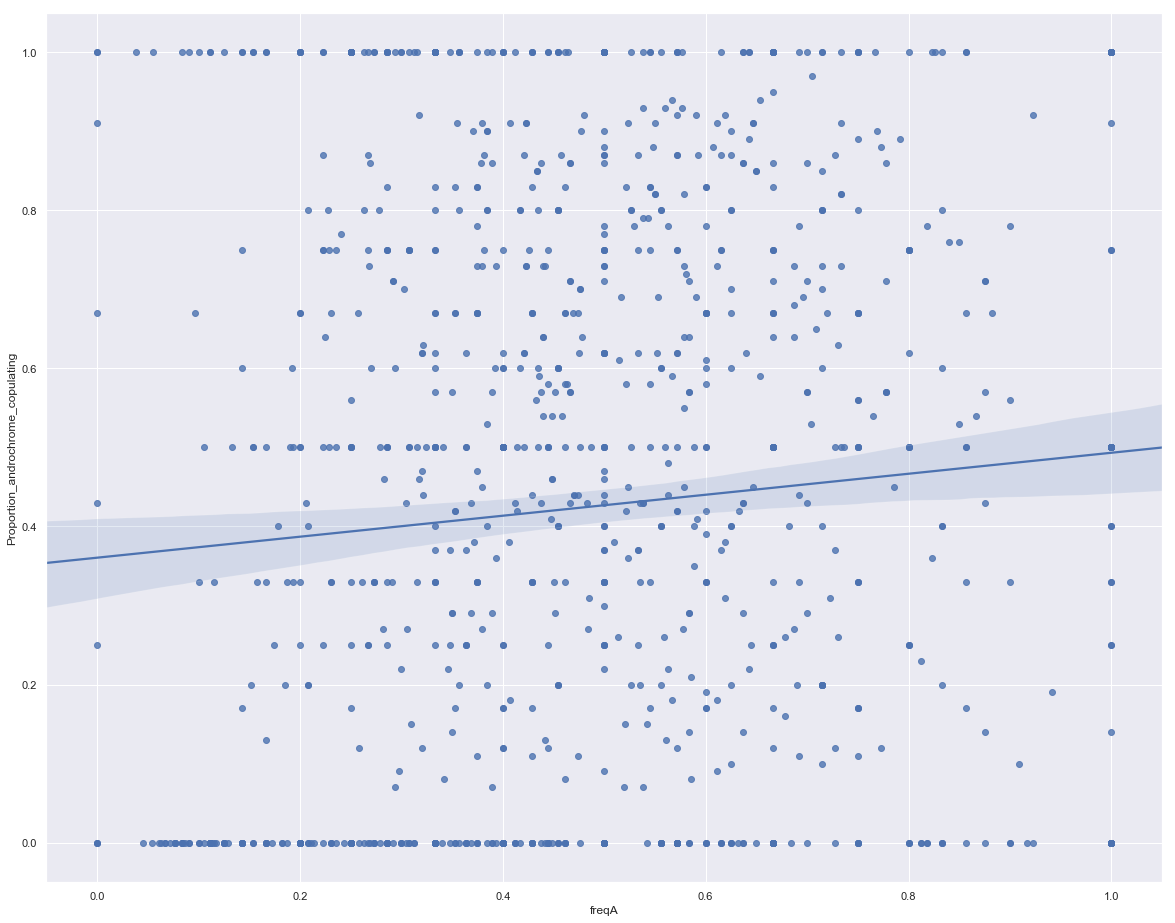

In [18]:
aComp = smf.ols(formula="Proportion_androchrome_copulating~freqA", data=dens[pd.notnull(dens["freqA"])], missing='drop').fit()
print(aComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="freqA", y="Proportion_androchrome_copulating", data=dens, ax=axarr)

                                   OLS Regression Results                                  
Dep. Variable:     Proportion_infuscans_copulating   R-squared:                       0.006
Model:                                         OLS   Adj. R-squared:                  0.005
Method:                              Least Squares   F-statistic:                     5.652
Date:                             Mon, 02 Sep 2019   Prob (F-statistic):             0.0176
Time:                                     11:04:06   Log-Likelihood:                -440.23
No. Observations:                              905   AIC:                             884.5
Df Residuals:                                  903   BIC:                             894.1
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

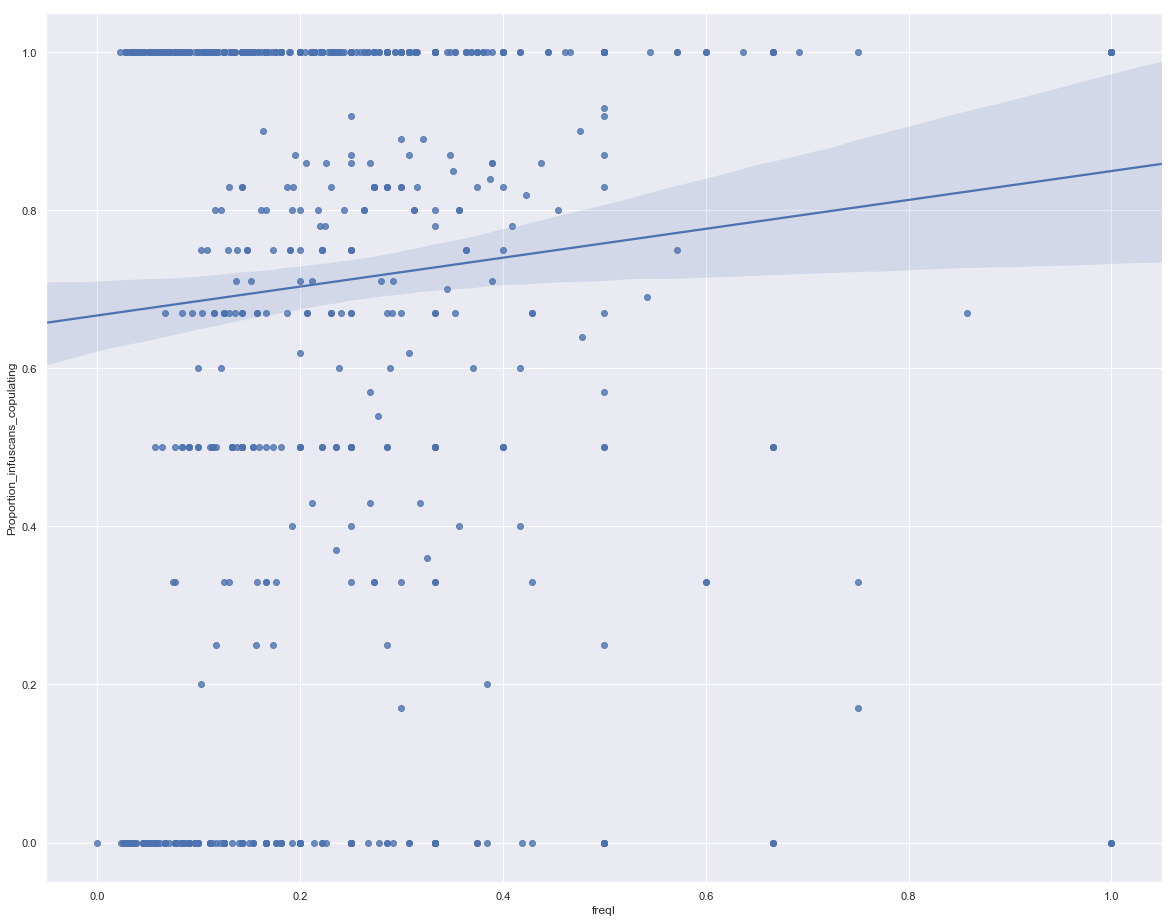

In [19]:
iComp = smf.ols(formula="Proportion_infuscans_copulating~freqI", data=dens[pd.notnull(dens["freqI"])], missing='drop').fit()
print(iComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="freqI", y="Proportion_infuscans_copulating", data=dens, ax=axarr)

                                       OLS Regression Results                                       
Dep. Variable:     Proportion_infuscans_obsoleta_copulating   R-squared:                       0.007
Model:                                                  OLS   Adj. R-squared:                  0.005
Method:                                       Least Squares   F-statistic:                     3.656
Date:                                      Mon, 02 Sep 2019   Prob (F-statistic):             0.0564
Time:                                              11:04:07   Log-Likelihood:                -310.38
No. Observations:                                       514   AIC:                             624.8
Df Residuals:                                           512   BIC:                             633.3
Df Model:                                                 1                                         
Covariance Type:                                  nonrobust                                

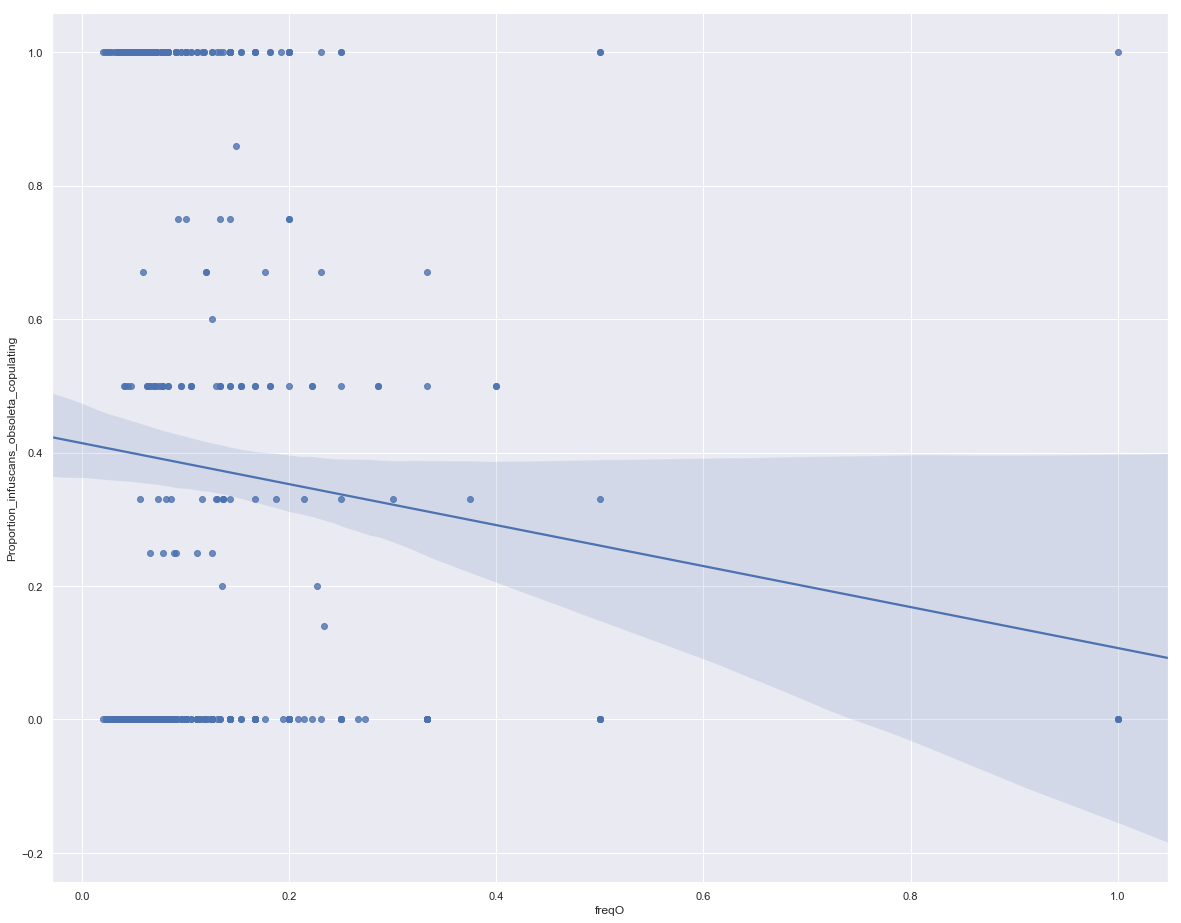

In [20]:
oComp = smf.ols(formula="Proportion_infuscans_obsoleta_copulating~freqO", data=dens[pd.notnull(dens["freqO"])], missing='drop').fit()
print(oComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="freqO", y="Proportion_infuscans_obsoleta_copulating", data=dens, ax=axarr)

                                    OLS Regression Results                                   
Dep. Variable:     Proportion_androchrome_copulating   R-squared:                       0.001
Model:                                           OLS   Adj. R-squared:                  0.001
Method:                                Least Squares   F-statistic:                     1.636
Date:                               Mon, 02 Sep 2019   Prob (F-statistic):              0.201
Time:                                       11:04:07   Log-Likelihood:                -517.06
No. Observations:                               1250   AIC:                             1038.
Df Residuals:                                   1248   BIC:                             1048.
Df Model:                                          1                                         
Covariance Type:                           nonrobust                                         
                 coef    std err          t      P>|t|      

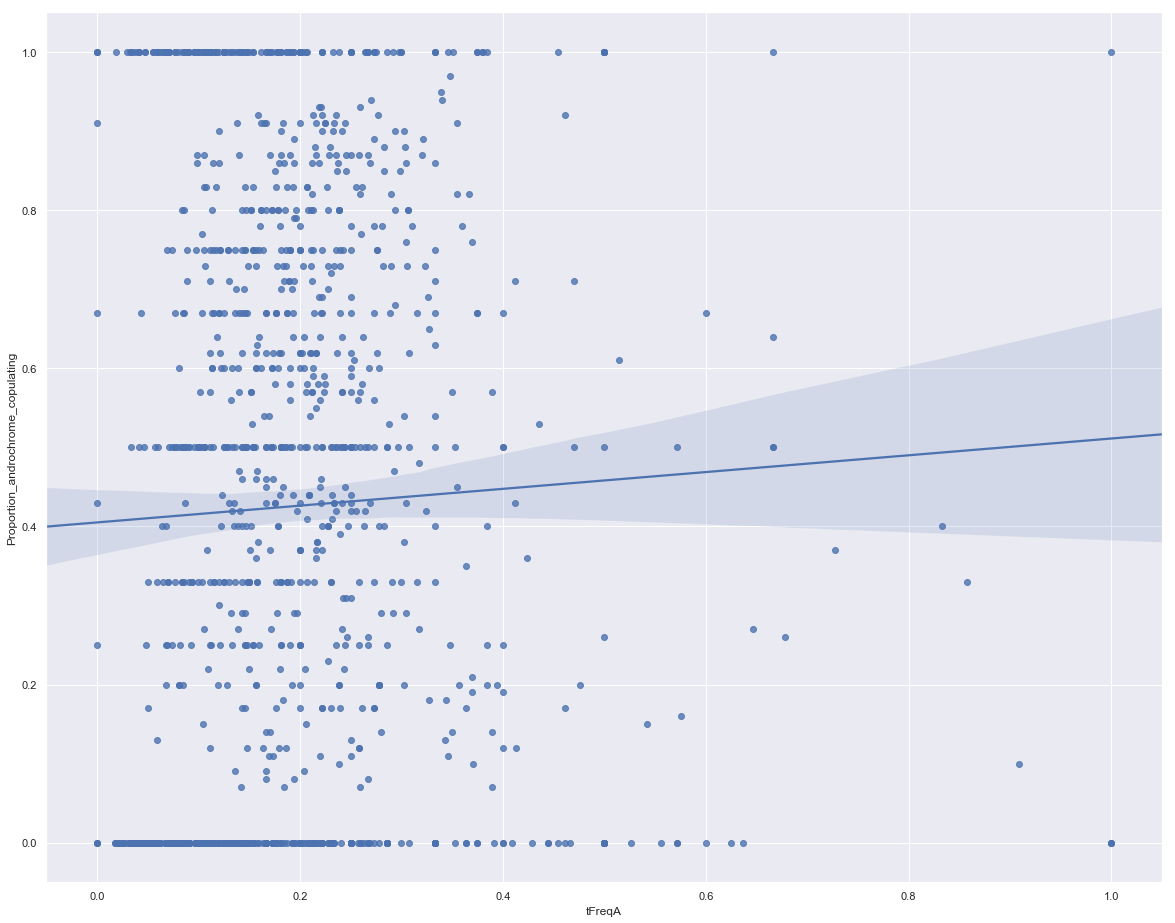

In [21]:
aComp = smf.ols(formula="Proportion_androchrome_copulating~tFreqA", data=dens[pd.notnull(dens["tFreqA"])], missing='drop').fit()
print(aComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="tFreqA", y="Proportion_androchrome_copulating", data=dens, ax=axarr)

c:\users\lorenzo\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


                                    OLS Regression Results                                   
Dep. Variable:     Proportion_androchrome_copulating   R-squared:                       0.019
Model:                                           OLS   Adj. R-squared:                  0.018
Method:                                Least Squares   F-statistic:                     23.81
Date:                               Mon, 02 Sep 2019   Prob (F-statistic):           1.20e-06
Time:                                       11:04:08   Log-Likelihood:                -506.07
No. Observations:                               1250   AIC:                             1016.
Df Residuals:                                   1248   BIC:                             1026.
Df Model:                                          1                                         
Covariance Type:                           nonrobust                                         
                   coef    std err          t      P>|t|    

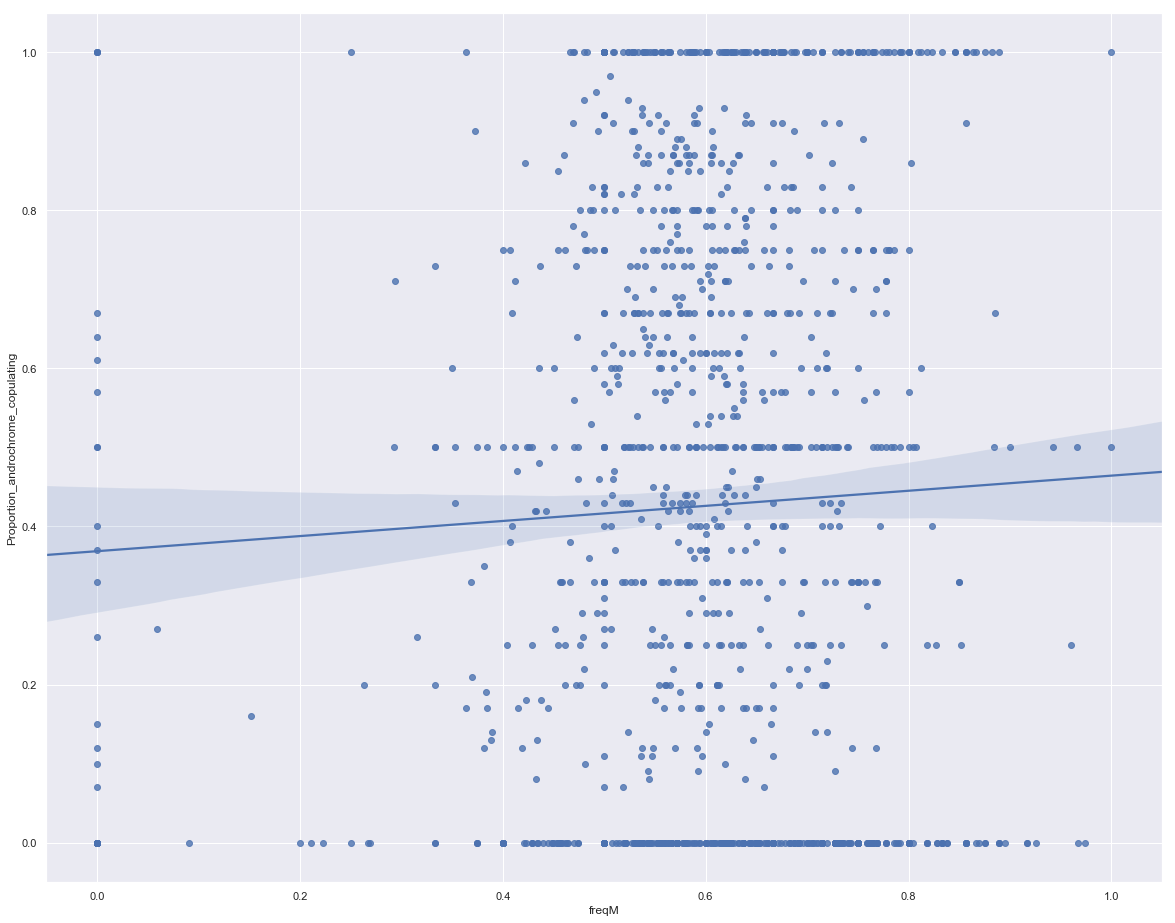

In [22]:
aComp = smf.ols(formula="Proportion_androchrome_copulating~freqM:tFreqA", data=dens[pd.notnull(dens["freqM"])][pd.notnull(dens["tFreqA"])], missing='drop').fit()
print(aComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="freqM", y="Proportion_androchrome_copulating", data=dens, ax=axarr)

                                    OLS Regression Results                                   
Dep. Variable:     Proportion_androchrome_copulating   R-squared:                       0.008
Model:                                           OLS   Adj. R-squared:                  0.007
Method:                                Least Squares   F-statistic:                     9.658
Date:                               Mon, 02 Sep 2019   Prob (F-statistic):            0.00193
Time:                                       11:04:09   Log-Likelihood:                -513.10
No. Observations:                               1248   AIC:                             1030.
Df Residuals:                                   1246   BIC:                             1040.
Df Model:                                          1                                         
Covariance Type:                           nonrobust                                         
                 coef    std err          t      P>|t|      

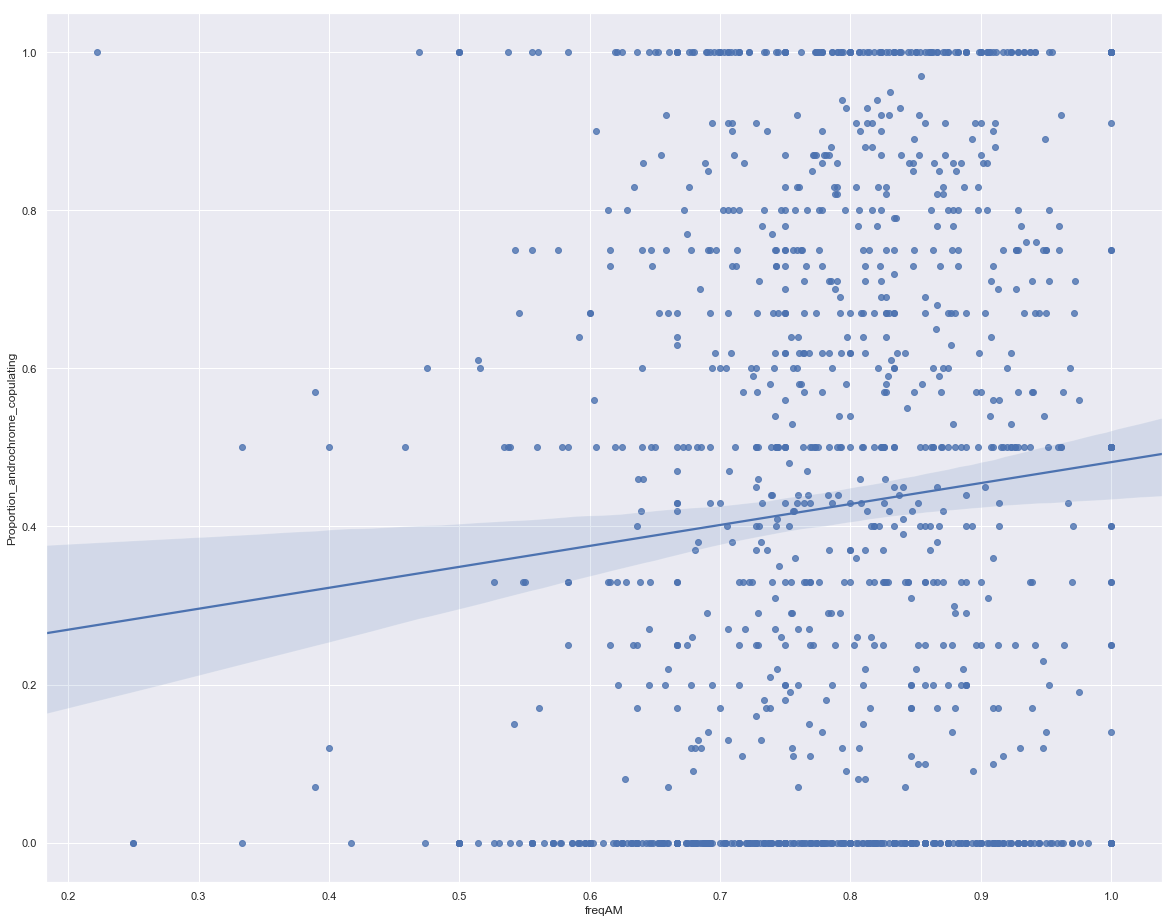

In [23]:
dens["freqAM"] = dens["freqM"]+dens["tFreqA"]
dens.loc[dens["freqAM"] > 1, "freqAM"] = np.nan

aComp = smf.ols(formula="Proportion_androchrome_copulating~freqAM", data=dens[pd.notnull(dens["freqAM"])], missing='drop').fit()
print(aComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="freqAM", y="Proportion_androchrome_copulating", data=dens, ax=axarr)

                                   OLS Regression Results                                  
Dep. Variable:     Proportion_infuscans_copulating   R-squared:                       0.003
Model:                                         OLS   Adj. R-squared:                  0.002
Method:                              Least Squares   F-statistic:                     2.969
Date:                             Mon, 02 Sep 2019   Prob (F-statistic):             0.0852
Time:                                     11:04:10   Log-Likelihood:                -441.83
No. Observations:                              906   AIC:                             887.7
Df Residuals:                                  904   BIC:                             897.3
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

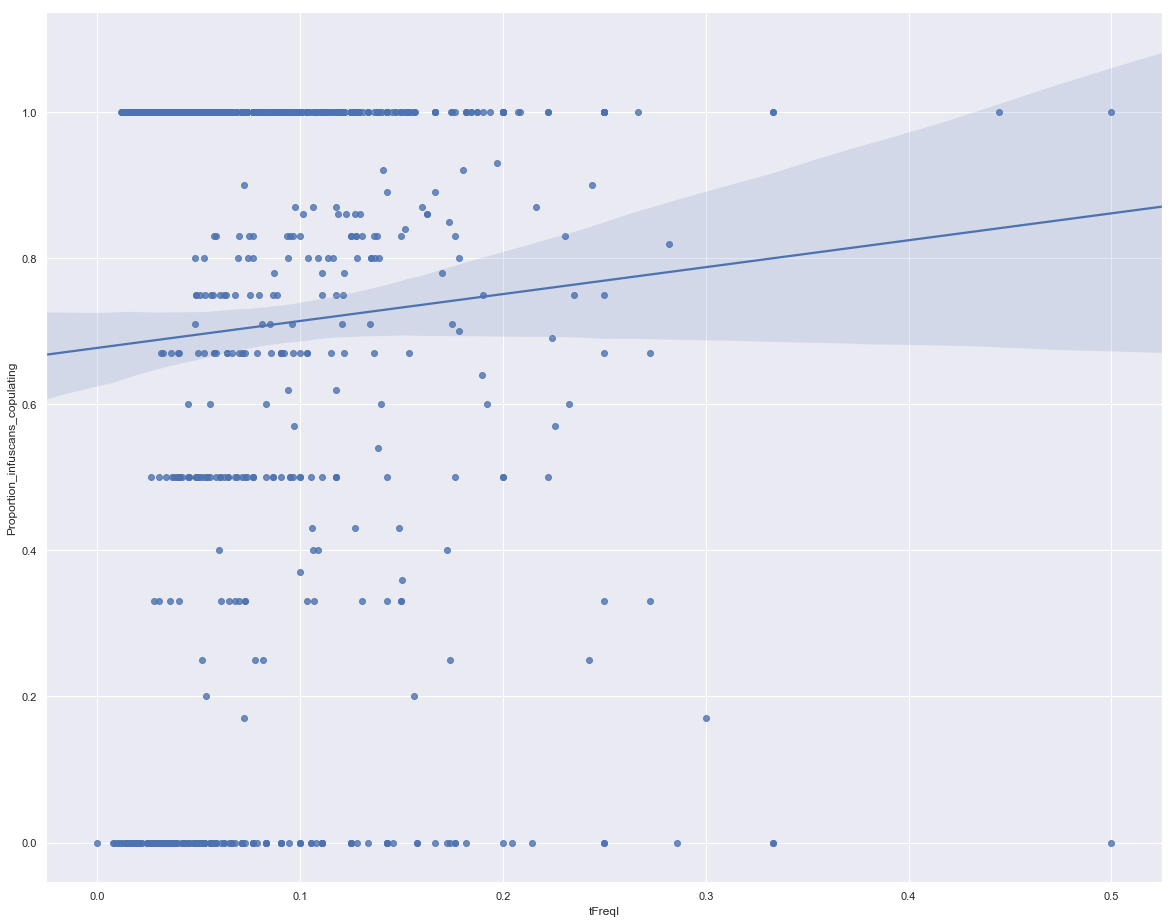

In [24]:
iComp = smf.ols(formula="Proportion_infuscans_copulating~tFreqI", data=dens[pd.notnull(dens["tFreqI"])], missing='drop').fit()
print(iComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="tFreqI", y="Proportion_infuscans_copulating", data=dens, ax=axarr)

                                       OLS Regression Results                                       
Dep. Variable:     Proportion_infuscans_obsoleta_copulating   R-squared:                       0.008
Model:                                                  OLS   Adj. R-squared:                  0.006
Method:                                       Least Squares   F-statistic:                     4.286
Date:                                      Mon, 02 Sep 2019   Prob (F-statistic):             0.0389
Time:                                              11:04:10   Log-Likelihood:                -309.13
No. Observations:                                       512   AIC:                             622.3
Df Residuals:                                           510   BIC:                             630.7
Df Model:                                                 1                                         
Covariance Type:                                  nonrobust                                

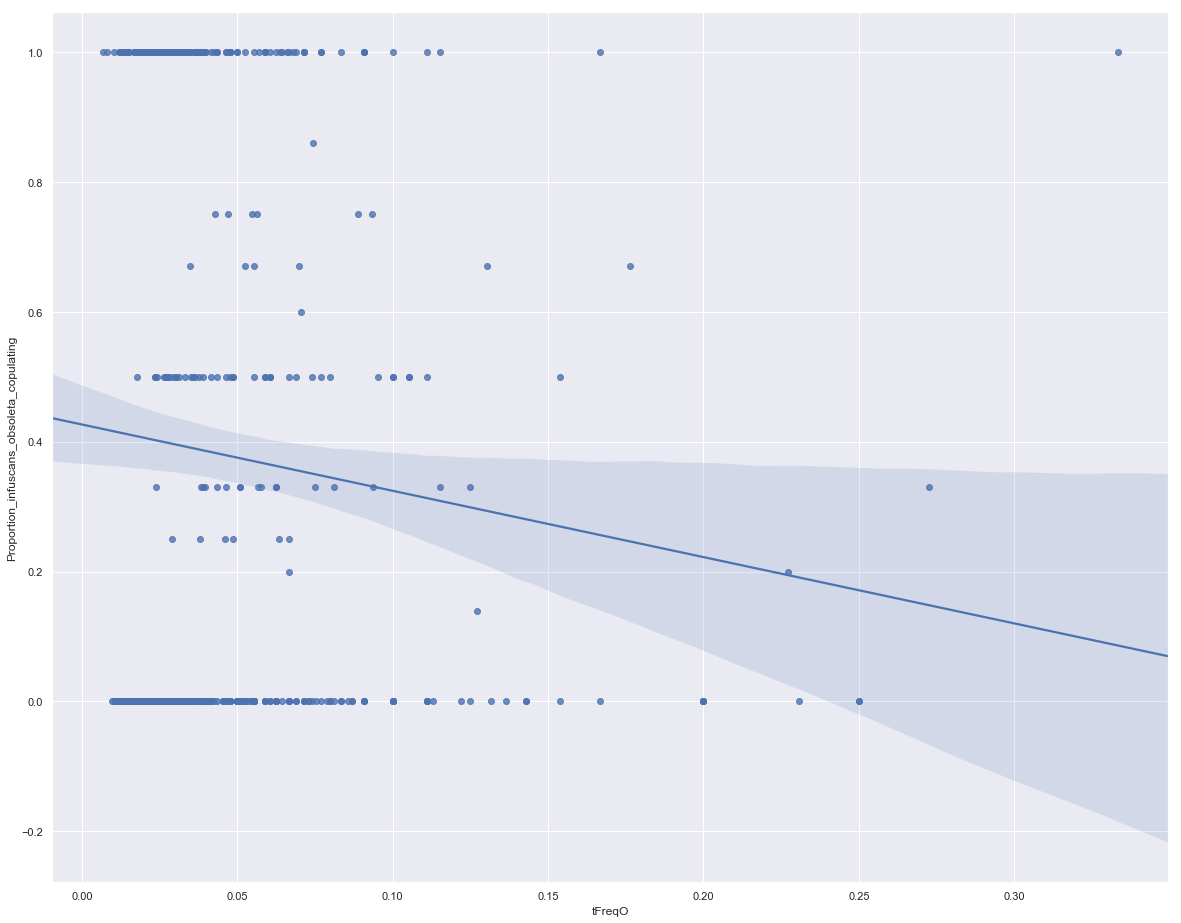

In [25]:
oComp = smf.ols(formula="Proportion_infuscans_obsoleta_copulating~tFreqO", data=dens[pd.notnull(dens["tFreqO"])], missing='drop').fit()
print(oComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="tFreqO", y="Proportion_infuscans_obsoleta_copulating", data=dens, ax=axarr)

                                       OLS Regression Results                                       
Dep. Variable:     Proportion_infuscans_obsoleta_copulating   R-squared:                       0.015
Model:                                                  OLS   Adj. R-squared:                  0.013
Method:                                       Least Squares   F-statistic:                     7.744
Date:                                      Mon, 02 Sep 2019   Prob (F-statistic):            0.00559
Time:                                              11:04:11   Log-Likelihood:                -308.35
No. Observations:                                       514   AIC:                             620.7
Df Residuals:                                           512   BIC:                             629.2
Df Model:                                                 1                                         
Covariance Type:                                  nonrobust                                

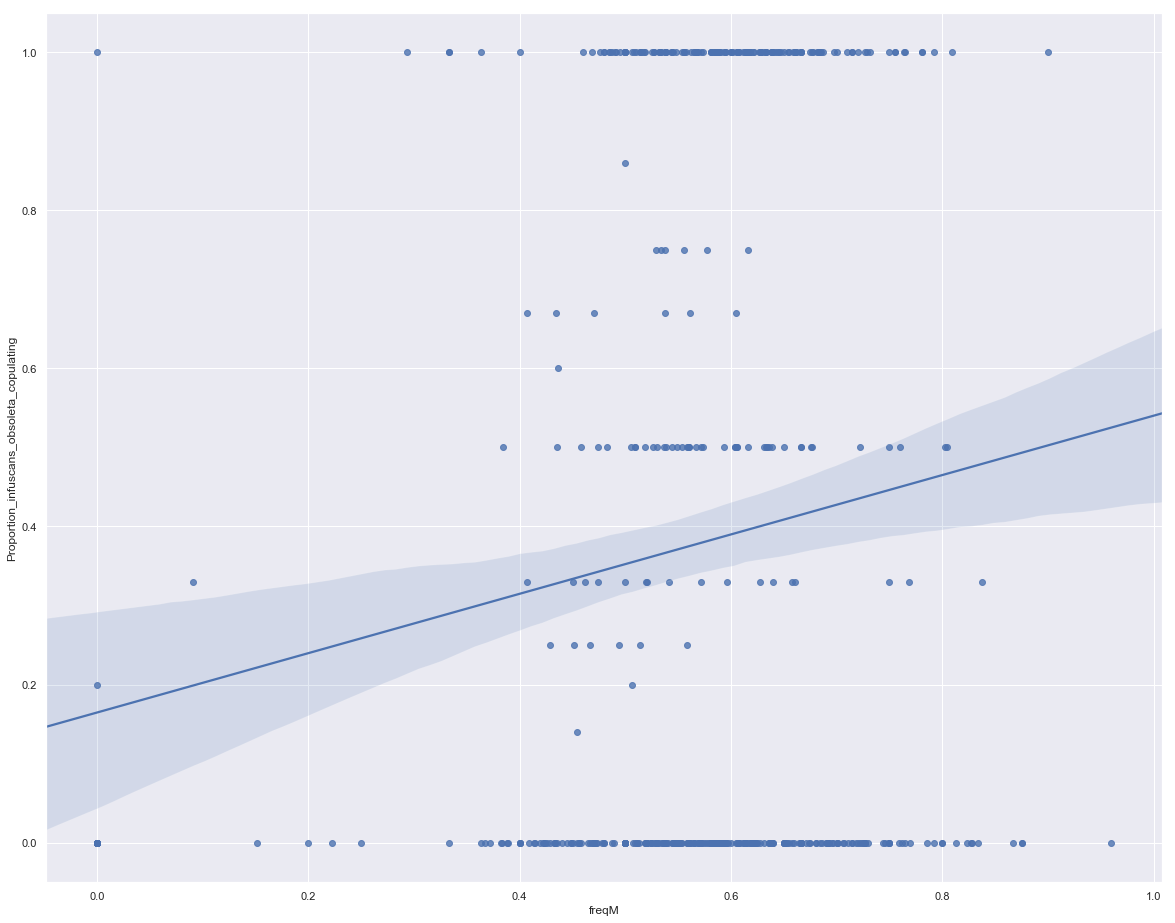

In [26]:
oComp = smf.ols(formula="Proportion_infuscans_obsoleta_copulating~freqM", data=dens[pd.notnull(dens["freqM"])], missing='drop').fit()
print(oComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="freqM", y="Proportion_infuscans_obsoleta_copulating", data=dens, ax=axarr)

                                   OLS Regression Results                                  
Dep. Variable:     Proportion_infuscans_copulating   R-squared:                       0.002
Model:                                         OLS   Adj. R-squared:                  0.001
Method:                              Least Squares   F-statistic:                     1.499
Date:                             Mon, 02 Sep 2019   Prob (F-statistic):              0.221
Time:                                     11:04:12   Log-Likelihood:                -442.56
No. Observations:                              906   AIC:                             889.1
Df Residuals:                                  904   BIC:                             898.7
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

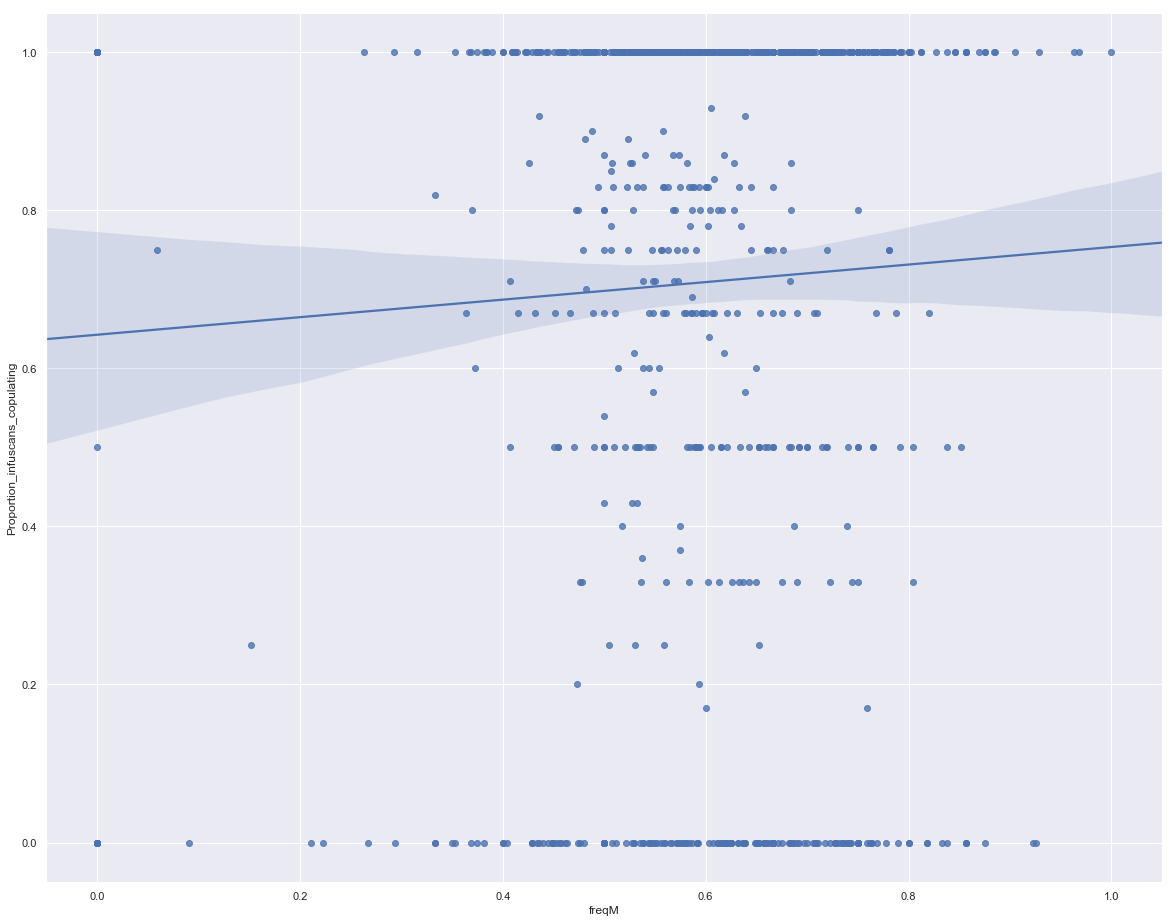

In [27]:
oComp = smf.ols(formula="Proportion_infuscans_copulating~freqM", data=dens[pd.notnull(dens["freqM"])], missing='drop').fit()
print(oComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="freqM", y="Proportion_infuscans_copulating", data=dens, ax=axarr)

In [28]:
def bestOlsModels(var):
    copA = {}
    for i in fullOptions:
        linReg = smf.ols(formula="{}~{}".format(var, i), data=dens[pd.notnull(dens["freqA"]) & pd.notnull(dens["freqI"]) & pd.notnull(dens["freqO"])], missing='drop').fit()
        copA[i] = linReg.aic
    s = [(k, copA[k]) for k in sorted(copA, key=copA.get, reverse=False)]
    for i, v in s:
        tresh = s[0][1]
        if np.exp((tresh-v)/2) > 0.5:
            linReg = smf.ols(formula="{}~{}".format(var, i), data=dens[pd.notnull(dens["freqA"]) & pd.notnull(dens["freqI"]) & pd.notnull(dens["freqO"])], missing='drop').fit()
            print(linReg.summary())
        else:
            break

In [29]:
bestOlsModels("Proportion_androchrome_copulating")
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="freqI", y="Proportion_androchrome_copulating", data=dens, ax=axarr)

NameError: name 'fullOptions' is not defined

In [ ]:
bestOlsModels("Proportion_infuscans_copulating")
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="freqA", y="Proportion_infuscans_copulating", data=dens, ax=axarr)

In [ ]:
bestOlsModels("Proportion_infuscans_obsoleta_copulating")
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="freqA", y="Proportion_infuscans_obsoleta_copulating", data=dens, ax=axarr)

In [ ]:
dens["matFem"] = dens["No_infuscans"]+dens["No_androchromes"]+dens["No_infuscans_obsoleta"]
dens["freqA"] = dens["No_androchromes"]/dens["matFem"]
dens.loc[dens["freqA"] > 1, "freqA"] = np.nan
dens["freqI"] = dens["No_infuscans"]/dens["matFem"]
dens.loc[dens["freqI"] > 1, "freqI"] = np.nan
dens["freqO"] = dens["No_infuscans_obsoleta"]/dens["matFem"]
dens.loc[dens["freqO"] > 1, "freqO"] = np.nan


test=dens[["freqA", "freqI", "freqO"]]

In [ ]:
aComp = smf.ols(formula="Proportion_androchrome_copulating~freqA", data=dens[pd.notnull(dens["freqA"])], missing='drop').fit()
print(aComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="freqA", y="Proportion_androchrome_copulating", data=dens, ax=axarr)

In [ ]:
iComp = smf.ols(formula="Proportion_infuscans_copulating~freqI", data=dens[pd.notnull(dens["freqI"])], missing='drop').fit()
print(iComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="freqI", y="Proportion_infuscans_copulating", data=dens, ax=axarr)

In [ ]:
oComp = smf.ols(formula="Proportion_infuscans_obsoleta_copulating~freqO", data=dens[pd.notnull(dens["freqO"])], missing='drop').fit()
print(oComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="freqO", y="Proportion_infuscans_obsoleta_copulating", data=dens, ax=axarr)

In [ ]:
bestOlsModels("Proportion_androchrome_copulating")
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="freqA", y="Proportion_androchrome_copulating", data=dens, ax=axarr)
fig.show()
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="freqI", y="Proportion_androchrome_copulating", data=dens, ax=axarr)
fig.show()
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="freqO", y="Proportion_androchrome_copulating", data=dens, ax=axarr)
fig.show()

In [ ]:
bestOlsModels("Proportion_infuscans_copulating")
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="freqO", y="Proportion_infuscans_copulating", data=dens, ax=axarr)

In [ ]:
bestOlsModels("Proportion_infuscans_obsoleta_copulating")
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="freqA", y="Proportion_infuscans_obsoleta_copulating", data=dens, ax=axarr)
fig.show()
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="freqI", y="Proportion_infuscans_obsoleta_copulating", data=dens, ax=axarr)
fig.show()
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="freqO", y="Proportion_infuscans_obsoleta_copulating", data=dens, ax=axarr)
fig.show()

In [ ]:
bestOlsModels("Mean_androchrome_fecundity")
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="freqA", y="Mean_androchrome_fecundity", data=dens, ax=axarr)
fig.show()

In [ ]:
bestOlsModels("Mean_infuscans_fecundity")

In [ ]:
bestOlsModels("Mean_infuscans_obsoleta_fecundity")

In [ ]:
bestOlsModels("Mean_androchrome_fecundity_incl_0")
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="freqA", y="Mean_androchrome_fecundity_incl_0", data=dens, ax=axarr)
fig.show()

In [ ]:
bestOlsModels("Mean_infuscans_fecundity_incl_0")

In [ ]:
bestOlsModels("Mean_infuscans_obsoleta_fecundity_incl_0")

# Log-transformed regression

In [ ]:
dens["lnACop"] = np.log(dens["Proportion_androchrome_copulating"]+.1)
dens["lnICop"] = np.log(dens["Proportion_infuscans_copulating"]+.00001)
dens["lnOCop"] = np.log(dens["Proportion_infuscans_obsoleta_copulating"]+.00001)
dens["lnAFec"] = np.log(dens["Mean_androchrome_fecundity"]+.00001)
dens["lnIFec"] = np.log(dens["Mean_infuscans_fecundity"]+.00001)
dens["lnOFec"] = np.log(dens["Mean_infuscans_obsoleta_fecundity"]+.00001)
dens["lnAFec0"] = np.log(dens["Mean_androchrome_fecundity_incl_0"]+.00001)
dens["lnIFec0"] = np.log(dens["Mean_infuscans_fecundity_incl_0"]+.00001)
dens["lnOFec0"] = np.log(dens["Mean_infuscans_obsoleta_fecundity_incl_0"]+.00001)
dens["lnAFreq"] = np.log(dens["freqA"]+.00001)
dens["lnIFreq"] = np.log(dens["freqI"]+.00001)
dens["lnOFreq"] = np.log(dens["freqO"]+.00001)

In [ ]:
#morphLoc = smf.ols(formula="freqA~Locale", data=densSub).fit()
#print(morphLoc.summary())
fig = plt.figure(figsize=(20,18))
sns.boxplot(x="Locale", y="freqO", data=densSub)

In [ ]:
dens["Species"].value_counts(dropna=False)

In [ ]:
subset = dens[["Season", "freqA", "Locale"]][dens.groupby("Locale")["Locale"].transform('count')>9]
sns.lineplot(data=subset, x="Season", y="freqA", hue="Locale")


In [ ]:
aComp = smf.ols(formula="Proportion_androchrome_copulating~No_indiv", data=dens, missing='drop').fit()
print(aComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="No_indiv", y="Proportion_androchrome_copulating", data=dens, ax=axarr)

In [ ]:
iComp = smf.ols(formula="Proportion_infuscans_copulating~No_indiv", data=dens, missing='drop').fit()
print(iComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="No_indiv", y="Proportion_infuscans_copulating", data=dens, ax=axarr)

In [ ]:
oComp = smf.ols(formula="Proportion_infuscans_obsoleta_copulating~No_indiv", data=dens, missing='drop').fit()
print(oComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="No_indiv", y="Proportion_infuscans_obsoleta_copulating", data=dens, ax=axarr)

In [ ]:
dens["lnInd"] = np.log(dens["No_indiv"])
aComp = smf.ols(formula="Proportion_androchrome_copulating~lnInd", data=dens[pd.notnull(dens["lnInd"])], missing='drop').fit()
print(aComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="lnInd", y="Proportion_androchrome_copulating", data=dens, ax=axarr)

In [ ]:
iComp = smf.ols(formula="Proportion_infuscans_copulating~lnInd", data=dens[pd.notnull(dens["lnInd"])], missing='drop').fit()
print(iComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="lnInd", y="Proportion_infuscans_copulating", data=dens, ax=axarr)

In [ ]:
oComp = smf.ols(formula="Proportion_infuscans_obsoleta_copulating~lnInd", data=dens[pd.notnull(dens["lnInd"])], missing='drop').fit()
print(oComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="lnInd", y="Proportion_infuscans_obsoleta_copulating", data=dens, ax=axarr)

In [ ]:
aComp = smf.ols(formula="Proportion_androchrome_copulating~lnInd+freqA", data=dens[pd.notnull(dens["lnInd"])][pd.notnull(dens["freqA"])], missing='drop').fit()
print(aComp.summary())

In [ ]:
iComp = smf.ols(formula="Proportion_infuscans_copulating~lnInd+freqI", data=dens[pd.notnull(dens["lnInd"])][pd.notnull(dens["freqI"])], missing='drop').fit()
print(iComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="lnInd", y="Proportion_infuscans_copulating", data=dens, ax=axarr)

In [ ]:
oComp = smf.ols(formula="Proportion_infuscans_obsoleta_copulating~lnInd+freqO", data=dens[pd.notnull(dens["lnInd"])][pd.notnull(dens["freqO"])], missing='drop').fit()
print(oComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="lnInd", y="Proportion_infuscans_obsoleta_copulating", data=dens, ax=axarr)

In [ ]:
aComp = smf.ols(formula="Proportion_androchrome_copulating~cpm", data=dens, missing='drop').fit()
print(aComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="cpm", y="Proportion_androchrome_copulating", data=dens, ax=axarr)

In [ ]:
iComp = smf.ols(formula="Proportion_infuscans_copulating~cpm", data=dens, missing='drop').fit()
print(iComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="cpm", y="Proportion_infuscans_copulating", data=dens, ax=axarr)

In [ ]:
oComp = smf.ols(formula="Proportion_infuscans_obsoleta_copulating~cpm", data=dens, missing='drop').fit()
print(oComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="cpm", y="Proportion_infuscans_obsoleta_copulating", data=dens, ax=axarr)

In [ ]:
dens["lnInd"] = np.log(dens["cpm"])
aComp = smf.ols(formula="Proportion_androchrome_copulating~lnInd", data=dens[pd.notnull(dens["lnInd"])], missing='drop').fit()
print(aComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="lnInd", y="Proportion_androchrome_copulating", data=dens, ax=axarr)

In [ ]:
iComp = smf.ols(formula="Proportion_infuscans_copulating~lnInd", data=dens[pd.notnull(dens["lnInd"])], missing='drop').fit()
print(iComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="lnInd", y="Proportion_infuscans_copulating", data=dens, ax=axarr)

In [ ]:
oComp = smf.ols(formula="Proportion_infuscans_obsoleta_copulating~lnInd", data=dens[pd.notnull(dens["lnInd"])], missing='drop').fit()
print(oComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="lnInd", y="Proportion_infuscans_obsoleta_copulating", data=dens, ax=axarr)

In [ ]:
aComp = smf.ols(formula="Proportion_androchrome_copulating~lnInd+freqA", data=dens[pd.notnull(dens["lnInd"])][pd.notnull(dens["freqA"])], missing='drop').fit()
print(aComp.summary())

In [ ]:
iComp = smf.ols(formula="Proportion_infuscans_copulating~lnInd+freqI", data=dens[pd.notnull(dens["lnInd"])][pd.notnull(dens["freqI"])], missing='drop').fit()
print(iComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="lnInd", y="Proportion_infuscans_copulating", data=dens, ax=axarr)

In [ ]:
oComp = smf.ols(formula="Proportion_infuscans_obsoleta_copulating~lnInd*freqO", data=dens[pd.notnull(dens["lnInd"])][pd.notnull(dens["freqO"])], missing='drop').fit()
print(oComp.summary())
fig, axarr = plt.subplots(1,1, figsize=(20,16))
plot1 = sns.regplot(x="lnInd", y="Proportion_infuscans_obsoleta_copulating", data=dens, ax=axarr)

In [ ]:
print(ind["Col_phas"].value_counts(dropna=False))
print(ind["Morph"].value_counts(dropna=False))
ind["Col_phas"][pd.isnull(ind["Col_phas"])] = "mature"
chiSquare(ind["Morph"], ind["Col_phas"])

In [ ]:
ind[ind["Morph"]=="infuscans-obsoleta"]["Copula"].value_counts(dropna=False, sort=False)